In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, f1_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import os
import joblib
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CONFIG = {
    "dataset": "B",   # "A" or "B"

    # Dataset A
    "A": {
        "file": "/content/drive/MyDrive/wustl_iiot_2021.csv",       # your file path
        "cat_cols": ["SrcAddr", "DstAddr"],
        "drop_cols": ["StartTime", "LastTime", "Traffic"],
        "target_col": "Target",
        "d_model": 128,
        "num_layers": 3,
        "n_heads": 8,
        "batch_size": 256,
        "use_focal": False,
        "sample_frac": 0.2,
        "sample_n": None,        # or take exact number of rows
        "dataset_name": "network_attack"
    },

    # Dataset B
    "B": {
        "file": "/content/drive/MyDrive/creditcard.csv",      # credit card fraud dataset path
        "cat_cols": [],                # no categorical
        "drop_cols": [],
        "target_col": "Class",
        "d_model": 64,                 # smaller model (extreme imbalance)
        "num_layers": 2,
        "n_heads": 4,
        "batch_size": 128,
        "use_focal": True,              # focal loss works well here
        "sample_frac": 1,
        "sample_n": None,       # or pick exact number of rows
        "dataset_name": "fraud_transaction"
    }
}

In [ ]:
# -----------------
# Helper: stratified sampling
# -----------------
def stratified_sample(df, target_col, frac=None, n=None, random_state=42):
    """Return stratified sample keeping target ratio"""
    if frac is not None:
        df_sampled = df.groupby(target_col, group_keys=False)\
                       .apply(lambda x: x.sample(frac=frac, random_state=random_state))
    elif n is not None:
        # allocate samples proportional to class distribution
        class_counts = df[target_col].value_counts()
        total = class_counts.sum()
        df_sampled = []
        for c, count in class_counts.items():
            take = int(n * (count / total))
            df_sampled.append(df[df[target_col] == c].sample(n=take, random_state=random_state))
        df_sampled = pd.concat(df_sampled)
    else:
        df_sampled = df
    return df_sampled.sample(frac=1.0, random_state=random_state)  # shuffle

In [ ]:
# -----------------
# Dataset + preprocessing
# -----------------
def prepare_dataframes(df, cat_cols, drop_cols, target_col, test_size=0.15, val_size=0.15, random_state=42):
    """
    Splits dataframe into train/val/test with optional column dropping.
    - df: input DataFrame
    - cat_cols: list of categorical column names
    - target_col: anomaly/fraud label column
    - drop_cols: list of columns to drop before splitting (default None)
    """

    df = df.copy()

    # Drop unwanted columns if provided
    if drop_cols:
        df = df.drop(columns=drop_cols, errors="ignore")

    # Handle missing values
    df.fillna(method='ffill', inplace=True)

    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int).values
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    val_relative = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_relative, stratify=y_trainval, random_state=random_state
    )
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def fit_transform_preprocessors(X_train, X_val, X_test, cat_cols):
    num_cols = [c for c in X_train.columns if c not in cat_cols]
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[num_cols])
    X_val_num = scaler.transform(X_val[num_cols])
    X_test_num = scaler.transform(X_test[num_cols])
    encoders = {}
    if cat_cols:
        X_train_cat = np.zeros((len(X_train), len(cat_cols)), dtype=int)
        X_val_cat   = np.zeros((len(X_val), len(cat_cols)), dtype=int)
        X_test_cat  = np.zeros((len(X_test), len(cat_cols)), dtype=int)
        for i, c in enumerate(cat_cols):
            le = LabelEncoder()
            le.fit(pd.concat([X_train[c], X_val[c], X_test[c]], axis=0).astype(str))
            encoders[c] = le
            X_train_cat[:, i] = le.transform(X_train[c].astype(str))
            X_val_cat[:, i] = le.transform(X_val[c].astype(str))
            X_test_cat[:, i] = le.transform(X_test[c].astype(str))
    else:
        X_train_cat, X_val_cat, X_test_cat = None, None, None
    return num_cols, scaler, encoders, (X_train_num, X_val_num, X_test_num), (X_train_cat, X_val_cat, X_test_cat)


class TabularDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = X_num.astype(np.float32)
        self.X_cat = X_cat.astype(np.int64) if X_cat is not None else None
        self.y = y.astype(np.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x_num = torch.from_numpy(self.X_num[idx])
        x_cat = torch.from_numpy(self.X_cat[idx]) if self.X_cat is not None else torch.zeros(0, dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x_num, x_cat, y

In [ ]:
# -----------------
# Transformer model
# -----------------
class VanillaTransformer(nn.Module):
    def __init__(self, num_num_features, cat_cardinalities, feat_order,
                 num_feature_indices, cat_feature_indices,
                 d_model=128, n_heads=8, num_layers=3, d_ff=None, dropout=0.1):
        super().__init__()
        seq_len = len(feat_order)
        d_ff = d_ff or d_model * 4
        self.feature_embedding = nn.Parameter(torch.randn(seq_len, d_model) * 0.02)
        self.value_proj = nn.Linear(1, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, d_model) * 0.02)
        self.pos_embedding = nn.Parameter(torch.randn(seq_len + 1, d_model) * 0.02)
        self.cat_embs = nn.ModuleList([nn.Embedding(card, d_model) for card in cat_cardinalities])
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads,
                                                   dim_feedforward=d_ff, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(dropout)
        hidden = max(d_model // 2, 32)
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )
        self.num_pos = num_feature_indices
        self.cat_pos = cat_feature_indices

    def forward(self, x_num, x_cat):
        batch = x_num.shape[0]
        seq_len = self.feature_embedding.shape[0]
        tokens = self.feature_embedding.unsqueeze(0).expand(batch, -1, -1).clone()
        v = x_num.unsqueeze(-1)
        vproj = self.value_proj(v)
        for i, pos in enumerate(self.num_pos):
            tokens[:, pos, :] += vproj[:, i, :]
        for j, pos in enumerate(self.cat_pos):
            emb = self.cat_embs[j](x_cat[:, j])
            tokens[:, pos, :] += emb
        cls = self.cls_token.unsqueeze(0).expand(batch, -1, -1)
        tokens = torch.cat([cls, tokens], dim=1)
        tokens = tokens + self.pos_embedding.unsqueeze(0)
        tokens = self.dropout(tokens)
        tokens = tokens.permute(1, 0, 2)
        out = self.transformer_encoder(tokens)
        cls_out = out[0]
        logits = self.classifier(cls_out).squeeze(-1)
        return logits

    def forward_with_attention(self, x_num, x_cat):
        """
        Returns:
            logits: predicted anomaly score
            attn_weights: attention scores per feature token (after CLS pooling)
        """
        batch = x_num.shape[0]
        seq_len = self.feature_embedding.shape[0]
        tokens = self.feature_embedding.unsqueeze(0).expand(batch, -1, -1).clone()

        # Numeric projection
        vproj = self.value_proj(x_num.unsqueeze(-1))
        for i, pos in enumerate(self.num_pos):
            tokens[:, pos, :] += vproj[:, i, :]

        # Categorical embedding
        for j, pos in enumerate(self.cat_pos):
            emb = self.cat_embs[j](x_cat[:, j])
            tokens[:, pos, :] += emb

        # CLS token + positional embeddings
        cls = self.cls_token.unsqueeze(0).expand(batch, -1, -1)
        tokens = torch.cat([cls, tokens], dim=1)
        tokens = tokens + self.pos_embedding.unsqueeze(0)

        # Transformer expects (seq_len, batch, d_model)
        tokens = tokens.permute(1, 0, 2)

        # Collect attention weights per layer
        attn_weights_all = []
        out = tokens
        for layer in self.transformer_encoder.layers:
            # PyTorch's TransformerEncoderLayer does not return attention by default
            # So we compute manually using MultiheadAttention
            attn_module = layer.self_attn
            out2, attn_weights = attn_module(out, out, out, need_weights=True)
            out = layer.norm1(out + layer.dropout1(out2))
            out2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(out))))
            out = layer.norm2(out + layer.dropout2(out2))
            attn_weights_all.append(attn_weights.detach())  # shape: (batch, seq_len, seq_len)

        cls_out = out[0]  # CLS token
        logits = self.classifier(cls_out).squeeze(-1)

        # Aggregate attention to CLS token: which tokens contribute most
        # attn_weights_all[-1][:,0,:] -> attention from CLS to each feature
        attn_to_cls = attn_weights_all[-1][:, 0, :]  # shape: (batch, seq_len)
        # Ignore CLS itself
        attn_to_features = attn_to_cls[:, 1:]
        return logits, attn_to_features

    def forward_verbose(self, x_num, x_cat):
        batch = x_num.shape[0]
        seq_len = self.feature_embedding.shape[0]

        print("\n=== Raw numeric input ===")
        print(x_num)
        if x_cat.numel() > 0:
            print("\n=== Raw categorical input ===")
            print(x_cat)

        # --- Feature embeddings ---
        tokens = self.feature_embedding.unsqueeze(0).expand(batch, -1, -1).clone()
        print("\n=== Initial feature embeddings ===")
        print(tokens)

        # --- Numeric projection ---
        vproj = self.value_proj(x_num.unsqueeze(-1))
        print("\n=== Numeric projections ===")
        print(vproj)
        for i, pos in enumerate(self.num_pos):
            tokens[:, pos, :] += vproj[:, i, :]
        print("\n=== After adding numeric projections ===")
        print(tokens)

        # --- Categorical embeddings ---
        if x_cat.numel() > 0:
            for j, pos in enumerate(self.cat_pos):
                emb = self.cat_embs[j](x_cat[:, j])
                tokens[:, pos, :] += emb
        print("\n=== After adding categorical embeddings ===")
        print(tokens)

        # --- CLS token + positional embeddings ---
        cls = self.cls_token.unsqueeze(0).expand(batch, -1, -1)
        tokens = torch.cat([cls, tokens], dim=1)
        tokens = tokens + self.pos_embedding.unsqueeze(0)
        tokens = self.dropout(tokens)
        print("\n=== Tokens after CLS + positional embeddings ===")
        print(tokens)

        # --- Transformer layers (step-by-step) ---
        out = tokens.permute(1, 0, 2)  # (seq_len+1, batch, d_model)
        for i, layer in enumerate(self.transformer_encoder.layers):
            out = layer(out)
            print(f"\n=== After Transformer layer {i} ===")
            print(out.permute(1, 0, 2))  # (batch, seq_len+1, d_model)

        # --- CLS pooling + classifier ---
        cls_out = out[0]
        logits = self.classifier(cls_out).squeeze(-1)
        probs = torch.sigmoid(logits)

        print("\n=== CLS pooled representation ===")
        print(cls_out)
        print("\n=== Logits ===")
        print(logits)
        print("\n=== Probabilities ===")
        print(probs)

        return probs

In [ ]:
# -----------------
# Losses
# -----------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, logits, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        pt = torch.exp(-bce)
        focal = self.alpha * (1-pt) ** self.gamma * bce
        return focal.mean()

In [ ]:
# -----------------
# Training utils
# -----------------
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for x_num, x_cat, y in dataloader:
        x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x_num, x_cat)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * x_num.size(0)
    return total_loss / len(dataloader.dataset)

@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    ys, probs = [], []
    for x_num, x_cat, y in dataloader:
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        logits = model(x_num, x_cat)
        p = torch.sigmoid(logits).cpu().numpy()
        probs.append(p)
        ys.append(y.numpy())
    probs = np.concatenate(probs)
    ys = np.concatenate(ys)
    rocauc = roc_auc_score(ys, probs)
    prauc = average_precision_score(ys, probs)
    return {'y': ys, 'probs': probs, 'roc_auc': rocauc, 'pr_auc': prauc}

def select_best_threshold(y_val, probs_val):
    prec, rec, thresh = precision_recall_curve(y_val, probs_val)
    f1s = 2*prec*rec/(prec+rec+1e-8)
    best_idx = np.argmax(f1s)
    return thresh[best_idx], f1s[best_idx]

In [ ]:
# -----------------
# Helper: anomaly ratio check
# -----------------
def check_anomaly_ratio(loader, name=""):
    total, anomalies = 0, 0
    for _, _, y in loader:   # assuming dataset returns (x_num, x_cat, y)
        total += len(y)
        anomalies += (y == 1).sum().item()
    ratio = anomalies / total if total > 0 else 0
    print(f"{name}: {anomalies}/{total} anomalies ({ratio:.4%})")
    return anomalies, total, ratio

In [ ]:
# -----------------
# Main training flow
# -----------------
def main_training_flow(cfg, device='cuda'):
    # --- 1. Load dataset ---
    df = pd.read_csv(cfg["file"])

    # optional stratified sampling
    if cfg.get("sample_frac") or cfg.get("sample_n"):
        df = stratified_sample(df, cfg["target_col"],
                               frac=cfg.get("sample_frac"),
                               n=cfg.get("sample_n"))
        print(f"Sampled dataset shape: {df.shape}, anomaly ratio={df[cfg['target_col']].mean():.4%}")

    # --- 2. Preprocess / split ---
    cat_cols = cfg["cat_cols"]
    target_col = cfg["target_col"]
    drop_cols  = cfg.get("drop_cols")

    (X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_dataframes(
        df, cat_cols, drop_cols, target_col
    )

    num_cols, scaler, encoders, \
    (X_train_num, X_val_num, X_test_num), \
    (X_train_cat, X_val_cat, X_test_cat) = fit_transform_preprocessors(
        X_train, X_val, X_test, cat_cols
    )

    # --- 3. Build datasets/loaders ---
    train_ds = TabularDataset(X_train_num, X_train_cat if cat_cols else np.zeros((len(X_train),0)), y_train)
    val_ds   = TabularDataset(X_val_num,   X_val_cat if cat_cols else np.zeros((len(X_val),0)),   y_val)
    test_ds  = TabularDataset(X_test_num,  X_test_cat if cat_cols else np.zeros((len(X_test),0)), y_test)

    train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=cfg["batch_size"], shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=cfg["batch_size"], shuffle=False)

    # check anomaly ratios
    check_anomaly_ratio(train_loader, "Train")
    check_anomaly_ratio(val_loader, "Validation")
    check_anomaly_ratio(test_loader, "Test")

    # --- 4. Model setup ---
    feat_order = list(X_train.columns)
    num_feature_indices = [feat_order.index(c) for c in num_cols]
    cat_feature_indices = [feat_order.index(c) for c in cat_cols]
    cat_cardinalities   = [len(encoders[c].classes_) for c in cat_cols]

    model = VanillaTransformer(
        num_num_features=len(num_cols),
        cat_cardinalities=cat_cardinalities,
        feat_order=feat_order,
        num_feature_indices=num_feature_indices,
        cat_feature_indices=cat_feature_indices,
        d_model=cfg["d_model"], n_heads=cfg["n_heads"], num_layers=cfg["num_layers"]
    ).to(device)

    # --- 5. Loss function ---
    if cfg["use_focal"]:
        criterion = FocalLoss(alpha=0.9, gamma=2)
    else:
        n_pos, n_neg = (y_train==1).sum(), (y_train==0).sum()
        pos_weight = torch.tensor([n_neg/max(1,n_pos)], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

    # --- 6. Training loop with early stopping ---
    best_state, best_val_pr, patience, wait = None, -1.0, 5, 0
    for epoch in range(cfg.get("max_epochs", 30)):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_res = evaluate(model, val_loader, device)
        print(f"Epoch {epoch:02d} Loss={train_loss:.4f} Val PR-AUC={val_res['pr_auc']:.4f} ROC-AUC={val_res['roc_auc']:.4f}")
        if val_res['pr_auc'] > best_val_pr:
            best_val_pr = val_res['pr_auc']
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

    # --- 7. Load best state & threshold selection ---
    model.load_state_dict(best_state)
    val_res = evaluate(model, val_loader, device)
    best_thresh, best_f1 = select_best_threshold(val_res['y'], val_res['probs'])
    print("Best threshold:", best_thresh, "Val F1:", best_f1)

    # --- 8. Final test evaluation ---
    test_res = evaluate(model, test_loader, device)
    preds = (test_res['probs'] >= best_thresh).astype(int)
    print("Test PR-AUC:", test_res['pr_auc'], "ROC-AUC:", test_res['roc_auc'])
    print(classification_report(test_res['y'], preds, digits=4))

    cm = confusion_matrix(test_res['y'], preds)

    # Print raw numbers
    print("Confusion Matrix:\n", cm)

    # Plot nicely
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    # --- 9. Save model + preprocessors + loaders metadata ---
    drive_folder = '/content/drive/MyDrive/anomaly_models'
    os.makedirs(drive_folder, exist_ok=True)

    # Save model
    model_path = os.path.join(drive_folder, f"transformer_{cfg['dataset_name']}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"✅ Model saved to {model_path}")

    # Save scalers/encoders
    joblib.dump(scaler,   os.path.join(drive_folder, f"scaler_{cfg['dataset_name']}.pkl"))
    joblib.dump(encoders, os.path.join(drive_folder, f"encoders_{cfg['dataset_name']}.pkl"))

    # Save threshold
    with open(os.path.join(drive_folder, f"threshold_{cfg['dataset_name']}.txt"), "w") as f:
        f.write(str(best_thresh))

    # Save dataset splits
    np.savez_compressed(os.path.join(drive_folder, f"splits_{cfg['dataset_name']}.npz"),
                        X_train_num=X_train_num, X_val_num=X_val_num, X_test_num=X_test_num,
                        X_train_cat=X_train_cat, X_val_cat=X_val_cat, X_test_cat=X_test_cat,
                        y_train=y_train, y_val=y_val, y_test=y_test)

    # --- 10. Return model, preprocessors, threshold, and splits for inspection ---
    return model, scaler, encoders, best_thresh, \
        (X_train_num, X_val_num, X_test_num,
          X_train_cat, X_val_cat, X_test_cat,
          y_train, y_val, y_test), \
        (train_loader, val_loader, test_loader), \
        (num_cols, feat_order, num_feature_indices, cat_feature_indices)


In [ ]:
# -----------------
# Main training flow
# -----------------
def main_training_flow(cfg, device='cuda'):
    # --- 1. Load dataset ---
    df = pd.read_csv(cfg["file"])

    # optional stratified sampling
    if cfg.get("sample_frac") or cfg.get("sample_n"):
        df = stratified_sample(df, cfg["target_col"],
                               frac=cfg.get("sample_frac"),
                               n=cfg.get("sample_n"))
        print(f"Sampled dataset shape: {df.shape}, anomaly ratio={df[cfg['target_col']].mean():.4%}")

    # --- 2. Preprocess / split ---
    cat_cols = cfg["cat_cols"]
    target_col = cfg["target_col"]
    drop_cols  = cfg.get("drop_cols")

    (X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_dataframes(
        df, cat_cols, drop_cols, target_col
    )

    num_cols, scaler, encoders, \
    (X_train_num, X_val_num, X_test_num), \
    (X_train_cat, X_val_cat, X_test_cat) = fit_transform_preprocessors(
        X_train, X_val, X_test, cat_cols
    )

    # --- 3. Build datasets/loaders ---
    train_ds = TabularDataset(X_train_num, X_train_cat if cat_cols else np.zeros((len(X_train),0)), y_train)
    val_ds   = TabularDataset(X_val_num,   X_val_cat if cat_cols else np.zeros((len(X_val),0)),   y_val)
    test_ds  = TabularDataset(X_test_num,  X_test_cat if cat_cols else np.zeros((len(X_test),0)), y_test)

    train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=cfg["batch_size"], shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=cfg["batch_size"], shuffle=False)

    # check anomaly ratios
    check_anomaly_ratio(train_loader, "Train")
    check_anomaly_ratio(val_loader, "Validation")
    check_anomaly_ratio(test_loader, "Test")

    # --- 4. Model setup ---
    feat_order = list(X_train.columns)
    num_feature_indices = [feat_order.index(c) for c in num_cols]
    cat_feature_indices = [feat_order.index(c) for c in cat_cols]
    cat_cardinalities   = [len(encoders[c].classes_) for c in cat_cols]

    model = VanillaTransformer(
        num_num_features=len(num_cols),
        cat_cardinalities=cat_cardinalities,
        feat_order=feat_order,
        num_feature_indices=num_feature_indices,
        cat_feature_indices=cat_feature_indices,
        d_model=cfg["d_model"], n_heads=cfg["n_heads"], num_layers=cfg["num_layers"]
    ).to(device)

    # --- 5. Loss function ---
    if cfg["use_focal"]:
        criterion = FocalLoss(alpha=0.9, gamma=2)
    else:
        n_pos, n_neg = (y_train==1).sum(), (y_train==0).sum()
        pos_weight = torch.tensor([n_neg/max(1,n_pos)], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

    # --- 6. Training loop with early stopping ---
    best_state, best_val_pr, patience, wait = None, -1.0, 5, 0
    for epoch in range(cfg.get("max_epochs", 30)):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_res = evaluate(model, val_loader, device)
        print(f"Epoch {epoch:02d} Loss={train_loss:.4f} Val PR-AUC={val_res['pr_auc']:.4f} ROC-AUC={val_res['roc_auc']:.4f}")
        if val_res['pr_auc'] > best_val_pr:
            best_val_pr = val_res['pr_auc']
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

    # --- 7. Load best state & threshold selection ---
    model.load_state_dict(best_state)
    val_res = evaluate(model, val_loader, device)
    best_thresh, best_f1 = select_best_threshold(val_res['y'], val_res['probs'])
    print("Best threshold:", best_thresh, "Val F1:", best_f1)

    # --- 8. Final test evaluation ---
    test_res = evaluate(model, test_loader, device)
    preds = (test_res['probs'] >= best_thresh).astype(int)
    print("Test PR-AUC:", test_res['pr_auc'], "ROC-AUC:", test_res['roc_auc'])
    print(classification_report(test_res['y'], preds, digits=4))
    print("AUC-ROC:", roc_auc_score(test_res['y'], preds))

    cm = confusion_matrix(test_res['y'], preds)

    # Print raw numbers
    print("Confusion Matrix:\n", cm)

    # Plot nicely
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    # --- 9. Save model + preprocessors + loaders metadata ---
    drive_folder = '/content/drive/MyDrive/anomaly_models'
    os.makedirs(drive_folder, exist_ok=True)

    # Save model
    model_path = os.path.join(drive_folder, f"transformer_{cfg['dataset_name']}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"✅ Model saved to {model_path}")

    # Save scalers/encoders
    joblib.dump(scaler,   os.path.join(drive_folder, f"scaler_{cfg['dataset_name']}.pkl"))
    joblib.dump(encoders, os.path.join(drive_folder, f"encoders_{cfg['dataset_name']}.pkl"))

    # Save threshold
    with open(os.path.join(drive_folder, f"threshold_{cfg['dataset_name']}.txt"), "w") as f:
        f.write(str(best_thresh))

    # Save dataset splits
    np.savez_compressed(os.path.join(drive_folder, f"splits_{cfg['dataset_name']}.npz"),
                        X_train_num=X_train_num, X_val_num=X_val_num, X_test_num=X_test_num,
                        X_train_cat=X_train_cat, X_val_cat=X_val_cat, X_test_cat=X_test_cat,
                        y_train=y_train, y_val=y_val, y_test=y_test)

    # --- 10. Return model, preprocessors, threshold, and splits for inspection ---
    return model, scaler, encoders, best_thresh, \
        (X_train_num, X_val_num, X_test_num,
          X_train_cat, X_val_cat, X_test_cat,
          y_train, y_val, y_test), \
        (train_loader, val_loader, test_loader), \
        (num_cols, feat_order, num_feature_indices, cat_feature_indices)

/tmp/ipython-input-921063323.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=frac, random_state=random_state))
/tmp/ipython-input-332726257.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Sampled dataset shape: (284807, 31), anomaly ratio=0.1727%
Train: 344/199364 anomalies (0.1725%)
Validation: 74/42721 anomalies (0.1732%)
Test: 74/42722 anomalies (0.1732%)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 00 Loss=0.0034 Val PR-AUC=0.4184 ROC-AUC=0.9281
Epoch 01 Loss=0.0017 Val PR-AUC=0.4598 ROC-AUC=0.9344
Epoch 02 Loss=0.0016 Val PR-AUC=0.4757 ROC-AUC=0.9425
Epoch 03 Loss=0.0016 Val PR-AUC=0.4818 ROC-AUC=0.9490
Epoch 04 Loss=0.0016 Val PR-AUC=0.5004 ROC-AUC=0.9498
Epoch 05 Loss=0.0015 Val PR-AUC=0.5499 ROC-AUC=0.9523
Epoch 06 Loss=0.0014 Val PR-AUC=0.6179 ROC-AUC=0.9588
Epoch 07 Loss=0.0013 Val PR-AUC=0.6750 ROC-AUC=0.9634
Epoch 08 Loss=0.0011 Val PR-AUC=0.7362 ROC-AUC=0.9680
Epoch 09 Loss=0.0011 Val PR-AUC=0.7500 ROC-AUC=0.9708
Epoch 10 Loss=0.0010 Val PR-AUC=0.7407 ROC-AUC=0.9718
Epoch 11 Loss=0.0010 Val PR-AUC=0.7477 ROC-AUC=0.9755
Epoch 12 Loss=0.0010 Val PR-AUC=0.7174 ROC-AUC=0.9764
Epoch 13 Loss=0.0010 Val PR-AUC=0.7362 ROC-AUC=0.9774
Epoch 14 Loss=0.0010 Val PR-AUC=0.7327 ROC-AUC=0.9789
Early stopping
Best threshold: 0.15031345 Val F1: 0.779220774228369
Test PR-AUC: 0.779410300973425 ROC-AUC: 0.9774451575942853
              precision    recall  f1-score   support

        

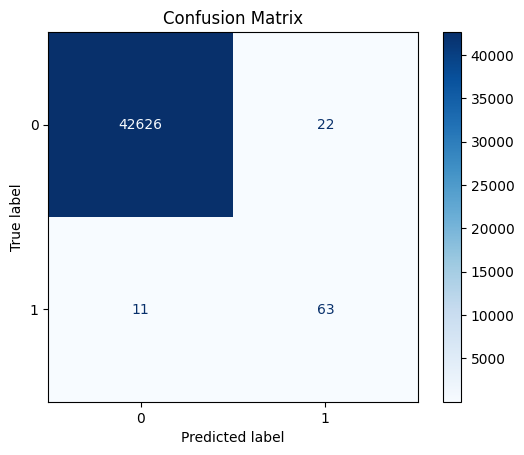

✅ Model saved to /content/drive/MyDrive/anomaly_models/transformer_fraud_transaction.pt


In [ ]:
# -----------------
# RUN
# -----------------
if __name__ == "__main__":
    cfg = CONFIG[CONFIG["dataset"]]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, scaler, encoders, thresh, splits, loaders, model_info = main_training_flow(cfg, device=device)

In [ ]:
X_train_num, X_val_num, X_test_num, X_train_cat, X_val_cat, X_test_cat, y_train, y_val, y_test = splits
train_loader, val_loader, test_loader = loaders

In [ ]:
import torch
import pandas as pd

all_true, all_probs, all_preds = [], [], []

# Loop through entire test set
with torch.no_grad():
    for x_num_batch, x_cat_batch, y_true_batch in test_loader:
        x_num_batch = x_num_batch.to(device)
        x_cat_batch = x_cat_batch.to(device)
        y_true_batch = y_true_batch.cpu().numpy()   # convert tensor to numpy

        logits = model(x_num_batch, x_cat_batch)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.6028694).astype(int)

        # ✅ extend with arrays/lists instead of tensor
        all_true.extend(y_true_batch.tolist())
        all_probs.extend(probs.flatten().tolist())
        all_preds.extend(preds.flatten().tolist())

# Combine into one DataFrame
inspect_df = pd.DataFrame({
    "True_Label": all_true,
    "Pred_Prob": all_probs,
    "Pred_Label": all_preds
})

print(inspect_df)

       True_Label  Pred_Prob  Pred_Label
0             0.0   0.045006           0
1             0.0   0.025735           0
2             0.0   0.026214           0
3             0.0   0.036927           0
4             0.0   0.024707           0
...           ...        ...         ...
42717         0.0   0.026955           0
42718         0.0   0.032246           0
42719         0.0   0.025662           0
42720         0.0   0.025805           0
42721         0.0   0.025466           0

[42722 rows x 3 columns]


In [ ]:
# Filter only positive class (True_Label == 1)
anomalies_df = inspect_df[inspect_df["True_Label"] == 1]

print(anomalies_df)

       True_Label  Pred_Prob  Pred_Label
735           1.0   0.657110           1
1243          1.0   0.025827           0
1289          1.0   0.171060           0
2147          1.0   0.042281           0
2581          1.0   0.686737           1
...           ...        ...         ...
36330         1.0   0.703105           1
37311         1.0   0.702154           1
38235         1.0   0.675292           1
39455         1.0   0.633843           1
40803         1.0   0.528883           0

[74 rows x 3 columns]


In [ ]:
# False negatives: True_Label=1 but Pred_Label=0
false_negatives = inspect_df[(inspect_df["True_Label"] == 1) & (inspect_df["Pred_Label"] == 0)]

print(false_negatives)

       True_Label  Pred_Prob  Pred_Label
1243          1.0   0.025827           0
1289          1.0   0.171060           0
2147          1.0   0.042281           0
4070          1.0   0.057570           0
4393          1.0   0.269272           0
5537          1.0   0.569246           0
6655          1.0   0.154472           0
7862          1.0   0.028873           0
9434          1.0   0.362218           0
9737          1.0   0.263251           0
10172         1.0   0.075358           0
10625         1.0   0.302247           0
16907         1.0   0.036808           0
17238         1.0   0.561285           0
20219         1.0   0.056827           0
20491         1.0   0.599950           0
22588         1.0   0.579989           0
23625         1.0   0.579449           0
27295         1.0   0.034472           0
29430         1.0   0.031592           0
29581         1.0   0.167269           0
30914         1.0   0.113156           0
31563         1.0   0.328525           0
31583         1.

In [ ]:
# False positivies: True_Label=1 but Pred_Label=0
false_positivies = inspect_df[(inspect_df["True_Label"] == 0) & (inspect_df["Pred_Label"] == 1)]

print(false_positivies)

       True_Label  Pred_Prob  Pred_Label
1292          0.0   0.688089           1
2876          0.0   0.644866           1
9389          0.0   0.633424           1
11960         0.0   0.710076           1
14376         0.0   0.627808           1
20599         0.0   0.706773           1
40939         0.0   0.611338           1


In [ ]:
# Pick first normal and first anomaly in test set
normal_idx = np.where(y_test == 0)[0][0]
anomaly_idx = np.where(y_test == 1)[0][0]

x_num_sample = torch.tensor(np.vstack([X_test_num[normal_idx], X_test_num[anomaly_idx]]), dtype=torch.float32)

# Handle the case where there are no categorical columns
#if cfg["cat_cols"]:
#    x_cat_sample = torch.tensor(np.vstack([X_test_cat[normal_idx], X_test_cat[anomaly_idx]]), dtype=torch.long)
#else:
#    x_cat_sample = torch.zeros((2, 0), dtype=torch.long)

x_cat_sample = torch.zeros((2, 0), dtype=torch.long)

y_sample = y_test[[normal_idx, anomaly_idx]]

print(normal_idx)
print(anomaly_idx)
print("Selected rows for inspection (labels):", y_sample)

0
735
Selected rows for inspection (labels): [0 1]


In [ ]:
num_cols, feat_order, num_feature_indices, cat_feature_indices = model_info

In [ ]:
model_inspect = VanillaTransformer(
    num_num_features=len(num_cols),
    #cat_cardinalities=[len(encoders[c].classes_) for c in ["SrcAddr", "DstAddr"]],
    cat_cardinalities=[],
    feat_order=feat_order,
    num_feature_indices=num_feature_indices,
    cat_feature_indices=cat_feature_indices,
    d_model=cfg["d_model"], n_heads=cfg["n_heads"], num_layers=cfg["num_layers"]
)
model_inspect.load_state_dict(model.state_dict())  # load trained weights
model_inspect.eval()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


VanillaTransformer(
  (value_proj): Linear(in_features=1, out_features=64, bias=True)
  (cat_embs): ModuleList()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_feature

In [ ]:
with torch.no_grad():
    probs = model_inspect.forward_verbose(x_num_sample, x_cat_sample)

print("\nPredicted probabilities (normal vs anomaly):", probs.numpy())


=== Raw numeric input ===
tensor([[ 1.0810, -1.3115, -0.9549,  1.3003,  3.6369,  1.6963, -0.3749, -0.2284,
          0.1931, -2.1417,  1.0814, -0.4822,  0.1696,  1.3993,  0.1470,  0.7720,
         -0.2649,  0.3732, -0.5349,  1.6968,  1.9624, -0.1273, -2.0310,  1.8133,
          1.7283,  0.0568, -0.2601, -0.1988,  0.5675,  0.6044],
        [ 1.1197,  0.6464,  1.6574, -3.5773,  3.7734,  1.0465, -1.0821, -0.7230,
          0.1033, -2.4999, -2.9293,  1.9527, -3.9865,  0.5810, -8.8342, -0.8679,
         -0.7616, -1.6095, -0.1233, -1.8038,  0.4043,  0.2825, -0.5882, -0.2521,
         -0.0315,  1.2144,  0.4013,  1.1597,  0.8827, -0.3388]])

=== Initial feature embeddings ===
tensor([[[-0.0280, -0.0095, -0.0249,  ...,  0.0204, -0.0048,  0.0300],
         [-0.0851, -0.0988, -0.0318,  ...,  0.0120, -0.0096, -0.0970],
         [ 0.0266, -0.0905, -0.0028,  ..., -0.0278,  0.0382, -0.1023],
         ...,
         [-0.0680, -0.0210,  0.0126,  ..., -0.0545,  0.0742, -0.1331],
         [-0.0874, -0.09

In [ ]:
with torch.no_grad():
    probs = model_inspect.forward_verbose(x_num_sample, x_cat_sample)

print("\nPredicted probabilities (normal vs anomaly):", probs.numpy())


=== Raw numeric input ===
tensor([[ 1.0810, -1.3115, -0.9549,  1.3003,  3.6369,  1.6963, -0.3749, -0.2284,
          0.1931, -2.1417,  1.0814, -0.4822,  0.1696,  1.3993,  0.1470,  0.7720,
         -0.2649,  0.3732, -0.5349,  1.6968,  1.9624, -0.1273, -2.0310,  1.8133,
          1.7283,  0.0568, -0.2601, -0.1988,  0.5675,  0.6044],
        [ 1.1197,  0.6464,  1.6574, -3.5773,  3.7734,  1.0465, -1.0821, -0.7230,
          0.1033, -2.4999, -2.9293,  1.9527, -3.9865,  0.5810, -8.8342, -0.8679,
         -0.7616, -1.6095, -0.1233, -1.8038,  0.4043,  0.2825, -0.5882, -0.2521,
         -0.0315,  1.2144,  0.4013,  1.1597,  0.8827, -0.3388]])

=== Initial feature embeddings ===
tensor([[[-0.0280, -0.0095, -0.0249,  ...,  0.0204, -0.0048,  0.0300],
         [-0.0851, -0.0988, -0.0318,  ...,  0.0120, -0.0096, -0.0970],
         [ 0.0266, -0.0905, -0.0028,  ..., -0.0278,  0.0382, -0.1023],
         ...,
         [-0.0680, -0.0210,  0.0126,  ..., -0.0545,  0.0742, -0.1331],
         [-0.0874, -0.09

In [ ]:
# -----------------
# Helper: get per-sample feature importance
# -----------------
def get_feature_importance(attn_scores, feature_names):
    """
    attn_scores: (batch_size, seq_len) attention from CLS to each feature token
    Returns: list of dicts per sample with normalized feature contributions
    """
    feature_importances = []
    for i in range(attn_scores.shape[0]):
        scores = attn_scores[i].cpu().numpy()
        scores = scores / scores.sum()  # normalize
        fi = dict(zip(feature_names, scores))
        fi = dict(sorted(fi.items(), key=lambda x: x[1], reverse=True))
        feature_importances.append(fi)
    return feature_importances

In [ ]:
all_idx, all_true, all_probs, all_preds, all_feature_importances = [], [], [], [], []

# Loop through entire test set
with torch.no_grad():
    for batch_idx, (x_num_batch, x_cat_batch, y_true_batch) in enumerate(test_loader):
        x_num_batch = x_num_batch.to(device)
        x_cat_batch = x_cat_batch.to(device)
        y_true_batch = y_true_batch.cpu().numpy()   # convert tensor to numpy

        logits, attn_to_features = model.forward_with_attention(x_num_batch, x_cat_batch)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.15031345).astype(int)

        # Calculate starting global index of this batch
        start_idx = batch_idx * test_loader.batch_size
        batch_indices = list(range(start_idx, start_idx + len(y_true_batch)))

        # ✅ extend with arrays/lists instead of tensor
        all_idx.extend(batch_indices)
        all_true.extend(y_true_batch.tolist())
        all_probs.extend(probs.flatten().tolist())
        all_preds.extend(preds.flatten().tolist())
        all_feature_importances.extend(get_feature_importance(attn_to_features, feat_order))


# Combine into one DataFrame
inspect_df = pd.DataFrame({
    "Idx": all_idx,
    "True_Label": all_true,
    "Pred_Prob": all_probs,
    "Pred_Label": all_preds,
    "Attn_Score": all_feature_importances
})

print(inspect_df)

print("Full test set distribution:")
print(inspect_df["True_Label"].value_counts(normalize=True))

# Take 50/50 stratified sample
n = 10  # or any number of samples you want
anomalies = inspect_df[inspect_df["True_Label"] == 1].sample(n=n//2, random_state=42)
normals   = inspect_df[inspect_df["True_Label"] == 0].sample(n=n//2, random_state=42)

balanced_df = pd.concat([anomalies, normals]).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("\nBalanced sample (50% anomalies, 50% normal):")
print(balanced_df)


print("\n=== Top contributing features for samples ===")
for i, row in balanced_df.head(10).iterrows():
    fi = row["Attn_Score"]   # dict from get_feature_importance
    top_feats = list(fi.items())[:5]
    print(f"Idx {row['Idx']} - True: {row['True_Label']} Predicted: {row['Pred_Label']} Prob: {row['Pred_Prob']:.4f}")
    for f, s in top_feats:
        print(f"  {f}: {s:.4f}")
    print("-----")


         Idx  True_Label  Pred_Prob  Pred_Label  \
0          0         0.0   0.045006           0   
1          1         0.0   0.025735           0   
2          2         0.0   0.026214           0   
3          3         0.0   0.036927           0   
4          4         0.0   0.024707           0   
...      ...         ...        ...         ...   
42717  42717         0.0   0.026955           0   
42718  42718         0.0   0.032246           0   
42719  42719         0.0   0.025662           0   
42720  42720         0.0   0.025805           0   
42721  42721         0.0   0.025467           0   

                                              Attn_Score  
0      {'V4': 0.1129176, 'V14': 0.066316135, 'V12': 0...  
1      {'V12': 0.10037377, 'V14': 0.096248366, 'V10':...  
2      {'V12': 0.09049723, 'V10': 0.08117844, 'V14': ...  
3      {'V14': 0.09495639, 'V19': 0.081323944, 'V10':...  
4      {'V12': 0.096918374, 'V14': 0.084809504, 'V10'...  
...                              

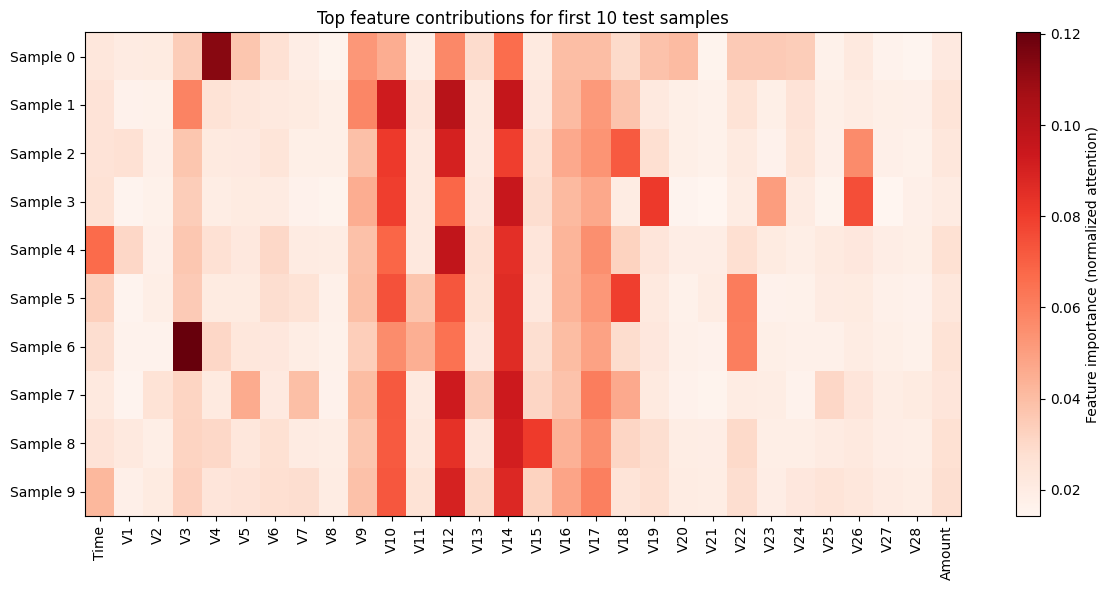

In [ ]:
# -----------------
# Visualize top feature contributions for first N test samples
# -----------------
N = min(10, len(all_feature_importances))
feature_matrix = np.zeros((N, len(feat_order)))
for i in range(N):
    fi = all_feature_importances[i]
    feature_matrix[i] = [fi[f] for f in feat_order]

plt.figure(figsize=(12, 6))
im = plt.imshow(feature_matrix, cmap="Reds", aspect="auto")
plt.colorbar(im, label="Feature importance (normalized attention)")
plt.yticks(range(N), [f"Sample {i}" for i in range(N)])
plt.xticks(range(len(feat_order)), feat_order, rotation=90)
plt.title(f"Top feature contributions for first {N} test samples")
plt.tight_layout()
plt.show()

In [ ]:
def get_model_feature_importance(model, x_num, x_cat, feature_names, device='cuda', top_n=5):
    """
    Returns top contributing features using three methods: attention, gradient, attention*gradient.

    Args:
        model: VanillaTransformer instance
        x_num: 1D numpy array of numeric features
        x_cat: 1D numpy array of categorical features (or None)
        feature_names: list of feature names (numeric)
        device: 'cuda' or 'cpu'
        top_n: number of top features to return

    Returns:
        dict with keys: 'attention', 'gradient', 'attention_gradient'
        each value is a list of tuples (feature_name, feature_value, score)
    """
    model.eval()

    # Prepare tensors
    x_num_tensor = torch.tensor(x_num[None, :], dtype=torch.float32, device=device, requires_grad=True)
    if x_cat is not None and x_cat.size > 0:
        x_cat_tensor = torch.tensor(x_cat[None, :], dtype=torch.long, device=device)
    else:
        x_cat_tensor = None

    # Forward pass
    logits, attn_to_features = model.forward_with_attention(x_num_tensor, x_cat_tensor)
    probs = torch.sigmoid(logits)

    # --- Gradient-only ---
    model.zero_grad()
    probs[0, None].backward()
    grads = x_num_tensor.grad[0].cpu().numpy()  # numeric gradients

    # --- Attention-only ---
    attn_scores = attn_to_features[0].cpu().numpy()

    # --- Attention x Gradient ---
    attn_grad = attn_scores * np.abs(grads)

    # Pair with feature names and values
    feature_values = x_num
    attention_contribs = list(zip(feature_names, feature_values, attn_scores))
    gradient_contribs = list(zip(feature_names, feature_values, grads))
    attn_grad_contribs = list(zip(feature_names, feature_values, attn_grad))

    # Sort each by absolute importance
    attention_top = sorted(attention_contribs, key=lambda x: abs(x[2]), reverse=True)[:top_n]
    gradient_top = sorted(gradient_contribs, key=lambda x: abs(x[2]), reverse=True)[:top_n]
    attn_grad_top = sorted(attn_grad_contribs, key=lambda x: abs(x[2]), reverse=True)[:top_n]

    return {
        "attention": attention_top,
        "gradient": gradient_top,
        "attention_gradient": attn_grad_top
    }

In [ ]:
i = 735
sample_num = X_test_num[i]
sample_cat = X_test_cat[i] if X_test_cat is not None else None

top_features = get_model_feature_importance(
    model, sample_num, sample_cat, num_cols, device=device, top_n=5
)

for method, feats in top_features.items():
    print(f"\n=== Top 5 features by {method} ===")
    for feat, val, score in feats:
        print(f"{feat} | Value: {val:.4f} | Score: {score:.4f}")


=== Top 5 features by attention ===
V17 | Value: -1.6095 | Score: 0.2262
V10 | Value: -2.9293 | Score: 0.1090
V16 | Value: -0.7616 | Score: 0.0922
V9 | Value: -2.4999 | Score: 0.0658
V19 | Value: -1.8038 | Score: 0.0584

=== Top 5 features by gradient ===
V17 | Value: -1.6095 | Score: -0.0358
V11 | Value: 1.9527 | Score: -0.0077
V2 | Value: 1.6574 | Score: -0.0071
V19 | Value: -1.8038 | Score: -0.0067
V25 | Value: 1.2144 | Score: -0.0067

=== Top 5 features by attention_gradient ===
V17 | Value: -1.6095 | Score: 0.0081
V19 | Value: -1.8038 | Score: 0.0004
V16 | Value: -0.7616 | Score: 0.0004
V6 | Value: -1.0821 | Score: 0.0003
V15 | Value: -0.8679 | Score: 0.0002



=== Global Feature Importance for Predicted Anomalies ===
V9: 0.0806
V10: 0.0756
Time: 0.0566
V6: 0.0513
V3: 0.0498


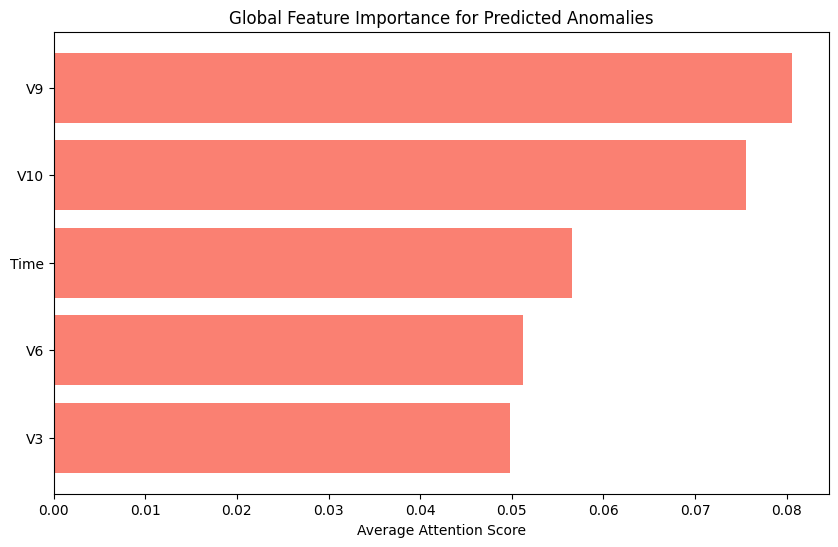

In [ ]:
from collections import defaultdict

# ---------------------------
# Filter only predicted anomalies
# ---------------------------
anomaly_indices = [i for i, p in enumerate(all_preds) if p == 1]
anomaly_feature_importances = [all_feature_importances[i] for i in anomaly_indices]

# ---------------------------
# Aggregate attention scores across anomalies
# ---------------------------
global_anomaly_importance = defaultdict(float)
for fi in anomaly_feature_importances:
    for f, s in fi.items():
        global_anomaly_importance[f] += s

# normalize by number of anomalous samples
num_anomalies = len(anomaly_feature_importances)
for f in global_anomaly_importance:
    global_anomaly_importance[f] /= max(num_anomalies, 1)

# sort descending
sorted_global_anom = sorted(global_anomaly_importance.items(), key=lambda x: x[1], reverse=True)

print("\n=== Global Feature Importance for Predicted Anomalies ===")
for f, s in sorted_global_anom[:5]:  # top 5 features
    print(f"{f}: {s:.4f}")

# Optional plot
top_features = [f for f, s in sorted_global_anom[:5]][::-1]
top_scores = [s for f, s in sorted_global_anom[:5]][::-1]

plt.figure(figsize=(10,6))
plt.barh(top_features, top_scores, color='salmon')
plt.xlabel("Average Attention Score")
plt.title("Global Feature Importance for Predicted Anomalies")
plt.show()

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=58c7ad987af63136648aa811ed998233f99d61468b65a8094d7ddbdd727b7fcb
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
def predict_fn(x):
    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(x_tensor, None)  # adjust if your forward expects categorical features too
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
    # LIME needs shape (n_samples, n_classes)
    return np.column_stack([1 - probs, probs])

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train_num,
    feature_names=num_cols,
    class_names=['Normal', 'Anomaly'],
    discretize_continuous=True,
    mode='classification'
)

# Pick one test sample
i = 735  # local index in test set
sample = X_test_num[i]

exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=lambda x: np.column_stack([1 - predict_fn(x), predict_fn(x)])
)

# Show results
exp.show_in_notebook(show_table=True)

contributions = exp.as_list()

# Extract actual feature values for this sample
feature_values = dict(zip(num_cols, sample))

# Build enriched list: (feature, value, contribution)
enriched = []
for feat, weight in contributions:
    # LIME formats features like "V17 <= -0.5" or "Amount > 120"
    base_feat = feat.split()[0]   # first token is feature name
    value = feature_values.get(base_feat, None)
    enriched.append((feat, value, weight))

# Sort by absolute contribution and take top 5
top5 = sorted(enriched, key=lambda x: abs(x[2]), reverse=True)[:5]

print("\n=== Top 5 contributing features with values ===")
for feat, val, weight in top5:
    print(f"{feat} | Value: {val:.4f} | Contribution: {weight:.4f}")


/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""



=== Top 5 contributing features with values ===
V14 <= -0.44 | Value: -8.8342 | Contribution: -0.0065
V4 > 0.53 | Value: 3.7734 | Contribution: -0.0045
V12 <= -0.41 | Value: -3.9865 | Contribution: -0.0034
V11 > 0.73 | Value: 1.9527 | Contribution: -0.0031
V17 <= -0.57 | Value: -1.6095 | Contribution: -0.0025


In [ ]:
import shap
import numpy as np

# Define a wrapper prediction function for SHAP
def shap_predict(x):
    # x is a 2D numpy array
    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(x_tensor, None)  # adapt if your forward expects cat features too
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
    return np.column_stack([1 - probs, probs])  # return [prob_normal, prob_anomaly]


In [ ]:
# Use a small subset of training data as background
background = X_train_num[:200]

explainer = shap.KernelExplainer(shap_predict, background)

In [ ]:
# Pick one test sample
i = 735  # local index in test set
sample = X_test_num[i]

# Run SHAP
shap_values = explainer.shap_values(sample, nsamples=100)

# shap_values is a list [for class 0, class 1], pick class 1 ("Anomaly")
shap_contrib = shap_values[1].flatten()

# Pair with feature names and values
feature_values = dict(zip(num_cols, sample))
contribs = list(zip(num_cols, sample, shap_contrib))

# Sort by absolute SHAP value (importance)
top5 = sorted(contribs, key=lambda x: abs(x[2]), reverse=True)[:5]

print("\n=== Top 5 contributing features (SHAP) ===")
for feat, val, weight in top5:
    print(f"{feat} | Value: {val:.4f} | SHAP: {weight:.4f}")


=== Top 5 contributing features (SHAP) ===
Time | Value: 1.1197 | SHAP: 0.0000
V1 | Value: 0.6464 | SHAP: 0.0000


In [ ]:
import shap

# SHAP Kernel Explainer
explainer_shap = shap.KernelExplainer(
    model=lambda x: predict_fn(x)[:,1],  # probability of "Anomaly"
    data=X_train_num[:100]  # small subset as background
)

# Compute SHAP values for one sample
shap_values = explainer_shap.shap_values(sample_num, nsamples=100)
# shap_values is a 2D array (features,)
shap_contribs = list(zip(num_cols, sample_num, shap_values))
shap_top5 = sorted(shap_contribs, key=lambda x: abs(x[2]), reverse=True)[:5]

print("\n=== Top 5 SHAP Features ===")
for f, v, s in shap_top5:
    print(f"{f} | Value: {v:.4f} | SHAP: {s:.4f}")


=== Top 5 SHAP Features ===
V14 | Value: -8.8342 | SHAP: 0.2881
V8 | Value: 0.1033 | SHAP: 0.0850
V17 | Value: -1.6095 | SHAP: 0.0586
V12 | Value: -3.9865 | SHAP: 0.0410
V25 | Value: 1.2144 | SHAP: 0.0356
